# Retail Sector Domain Analysis - Timeseries using RFM

## Libraries

In [51]:
#basic 
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import seaborn as sns
import plotly.express as px
import xlrd
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot

#datetime
import datetime
import datetime as dt

#lifetimes
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
# Clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples

#Data Scalling
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler,MaxAbsScaler


from math import sqrt
from scipy.stats import norm


import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

## loading data

In [2]:
retail = pd.read_excel('Retail-Ecommerce.xlsx', dtype= {'CustomerID': str})  
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365.0,71053.0,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Copying Data

In [3]:
#copy
data = retail.copy()

Checking shape of data

In [4]:
data.shape

(541909, 8)

### null values

In [5]:
#checking for the null values
data.isnull().sum()/data.shape[0]*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

#### Droping Null values

In [6]:
# first drop the rows where the description is null
data.dropna(axis = 0, subset = ["Description"], inplace = True)

In [7]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
Country             0
dtype: int64

In [8]:
#checking the data before droping these customer ID's
data[data["CustomerID"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544.0,21773.0,DECORATIVE ROSE BATHROOM BOTTLE,1.0,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544.0,21774.0,DECORATIVE CATS BATHROOM BOTTLE,2.0,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544.0,21786.0,POLKADOT RAIN HAT,4.0,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544.0,21787.0,RAIN PONCHO RETROSPOT,2.0,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544.0,21790.0,VINTAGE SNAP CARDS,9.0,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498.0,85099B,JUMBO BAG RED RETROSPOT,5.0,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498.0,85099C,JUMBO BAG BAROQUE BLACK WHITE,4.0,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498.0,85150.0,LADIES & GENTLEMEN METAL SIGN,1.0,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498.0,85174.0,S/4 CACTI CANDLES,1.0,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [9]:
data.iloc[575:, :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
575,536412.0,22144.0,CHRISTMAS CRAFT LITTLE FRIENDS,2.0,2010-12-01 11:49:00,2.10,17920.0,United Kingdom
576,536412.0,22243.0,5 HOOK HANGER RED MAGIC TOADSTOOL,3.0,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
577,536412.0,22077.0,6 RIBBONS RUSTIC CHARM,7.0,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
578,536412.0,21448.0,12 DAISY PEGS IN WOOD BOX,1.0,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
579,536412.0,22759.0,SET OF 3 NOTEBOOKS IN PARCEL,5.0,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587.0,22613.0,PACK OF 20 SPACEBOY NAPKINS,12.0,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587.0,22899.0,CHILDREN'S APRON DOLLY GIRL,6.0,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587.0,23254.0,CHILDRENS CUTLERY DOLLY GIRL,4.0,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587.0,23255.0,CHILDRENS CUTLERY CIRCUS PARADE,4.0,2011-12-09 12:50:00,4.15,12680.0,France


Dropping Null values of customer ID

In [10]:
data.dropna(axis = 0, subset = ["CustomerID"], inplace = True)

In [11]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## RFM Estimation - (Recency, Frequency, Monetary)
    
RFM stands for frequency, recency & monetary is a marketing technique which is used to find the best customers by analyzing their past purchasing behavior. It includes how frequently they have purchased, what is the total amount that they have spend so far, what was the last time they have purchased from our online store so on & so fort

In [12]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365.0,71053.0,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
data["Total Amount"] = data["Quantity"]*data["UnitPrice"]

In [14]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Amount
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365.0,71053.0,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [15]:
#which countries did we get the most income from
data.groupby("Country").agg({"Total Amount":"sum"}).sort_values("Total Amount", ascending = False).head()

,Total Amount
Country,
United Kingdom,6767873.394
Netherlands,284661.540
EIRE,250285.220
Germany,221698.210
France,196712.840


In [16]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [17]:
data['InvoiceDate'].describe()

count                  406829
unique                  20460
top       2011-11-14 15:27:00
freq                      543
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [18]:
#oldest shopping date
data["InvoiceDate"].min() 

Timestamp('2010-12-01 08:26:00')

In [19]:
 #newest shopping date
data["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [20]:
#to make the assessment easier, today's date is set as January 1, 2012.  
today = pd.datetime(2012,1,1) 
today

datetime.datetime(2012, 1, 1, 0, 0)

In [21]:
#changing the data type of the order date
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [22]:
#taking values greater than 0, this will be easier in terms of evaluation
df = data[data['Quantity'] > 0]
df = data[data['Total Amount'] > 0]

In [23]:
#removal of observation units with missing data from df
df.dropna(inplace = True)

In [24]:
#size information
df.shape

(397884, 9)

### Finding RFM Score¶
RFM consists of Recency, Frequency, Monetary initials of expressions.

It is a technique that helps determine marketing and sales strategies based on buying habits of customers.

1. Recency: Time since customer last purchase

2. Frequency: Total number of purchases.

3. Monetary: Total spending by the customer.

In [25]:
# finding Recency and Monetary values.
df_x = data.groupby('CustomerID').agg({'Total Amount': lambda x: x.sum(), #monetary value
                                        'InvoiceDate': lambda x: (today - x.max()).days}) #recency value
#x.max()).days; last shopping date of customers

In [26]:
#finding the frequency value per capital
df_y = df.groupby(['CustomerID','InvoiceNo']).agg({'Total Amount': lambda x: x.sum()})
df_z = df_y.groupby('CustomerID').agg({'Total Amount': lambda x: len(x)}) 


In [27]:
#creating the RFM table
rfm_table= pd.merge(df_x,df_z, on='CustomerID')

In [28]:
#determination of column names
rfm_table.rename(columns= {'InvoiceDate': 'Recency',
                          'Total Amount_y': 'Frequency',
                          'Total Amount_x': 'Monetary'}, inplace= True)

In [29]:
rfm_table.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,0.00,347,1
12347.0,4310.00,24,7
12348.0,1797.24,97,4
12349.0,1757.55,40,1
12350.0,334.40,332,1


In [30]:
#RFM score values 
rfm_table['RecencyScore'] = pd.qcut(rfm_table['Recency'],5,labels=[5,4,3,2,1])
rfm_table['FrequencyScore'] = pd.qcut(rfm_table['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
rfm_table['MonetaryScore'] = pd.qcut(rfm_table['Monetary'],5,labels=[1,2,3,4,5])

In [31]:
#RFM score values are combined side by side in str format
(rfm_table['RecencyScore'].astype(str) + 
 rfm_table['FrequencyScore'].astype(str) + 
 rfm_table['MonetaryScore'].astype(str)).head()

CustomerID
12346.0    111
12347.0    555
12348.0    244
12349.0    414
12350.0    112
dtype: object

In [32]:
#calculation of the RFM score
rfm_table["RFM_SCORE"] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str) + rfm_table['MonetaryScore'].astype(str)

In [33]:
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
CustomerID,,,,,,,
12346.0,0.00,347,1,1,1,1,111
12347.0,4310.00,24,7,5,5,5,555
12348.0,1797.24,97,4,2,4,4,244
12349.0,1757.55,40,1,4,1,4,414
12350.0,334.40,332,1,1,1,2,112


In [34]:
#customers with RFM Score 555
rfm_table[rfm_table["RFM_SCORE"] == "555"].head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
CustomerID,,,,,,,
12347.0,4310.00,24,7,5,5,5,555
12362.0,5154.58,25,10,5,5,5,555
12417.0,3578.80,25,9,5,5,5,555
12433.0,13375.87,22,7,5,5,5,555
12437.0,4896.66,23,18,5,5,5,555


In [35]:
#customers with RFM Score 111
rfm_table[rfm_table["RFM_SCORE"] == "111"].head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
CustomerID,,,,,,,
12346.0,0.0,347,1,1,1,1,111
12353.0,89.0,226,1,1,1,1,111
12361.0,189.9,309,1,1,1,1,111
12401.0,84.3,325,1,1,1,1,111
12402.0,225.6,345,1,1,1,1,111


### RFM Customer Segments
* Champions - bought recently, buy often and spend the most
* Loyal Customers - spend good money and often, responsive to promotions
* Potential Loyalist - recent customers, but spent a good amount and bought more than once
* New Customers - bought most recently, but not often
* Promising - recent shoppers, but haven’t spent much
* Needing Attention - above average recency, frequency and monetary values; may not have bought very recently though
* About To Sleep - below average recency, frequency and monetary values; will lose them if not reactivated
* At Risk - spent big money and purchased often but long time ago; need to bring them back
* Can't Loose Them - made biggest purchases, and often but haven’t returned for a long time
* Hibernating - last purchase was long back, low spenders and low number of orders

In [36]:
#segmenting of customers according to RecencyScore and FrequencyScore values
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Cannot Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [37]:
#creation of segment variable
rfm_table['Segment'] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(seg_map, regex=True)

With "regex = True", we used the names like "need attention", "can't lose" instead of RFM scores to the data set.

In [38]:
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
CustomerID,,,,,,,,
12346.0,0.00,347,1,1,1,1,111,Hibernating
12347.0,4310.00,24,7,5,5,5,555,Champions
12348.0,1797.24,97,4,2,4,4,244,At Risk
12349.0,1757.55,40,1,4,1,4,414,Promising
12350.0,334.40,332,1,1,1,2,112,Hibernating


In [39]:
rfm_table[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

Recency        Frequency           Monetary      
                           mean count       mean count         mean count
Segment                                                                  
About to Sleep        73.472464   345   1.168116   345   438.586348   345
At Risk              172.424242   594   2.880471   594   944.206618   594
Cannot Lose          149.553846    65   8.307692    65  2745.479846    65
Champions             26.989214   649  12.223421   649  6647.841171   649
Hibernating          236.419962  1062   1.097928  1062   402.366574  1062
Loyal Customers       53.565000   800   6.523750   800  2671.081939   800
Need Attention        71.333333   186   2.311828   186   809.068065   186
New Customers         27.847826    46   1.000000    46   384.548913    46
Potential Loyalists   37.443320   494   1.997976   494   694.911498   494
Promising             44.340206    97   1.000000    97   306.802887    97

#### Visualization

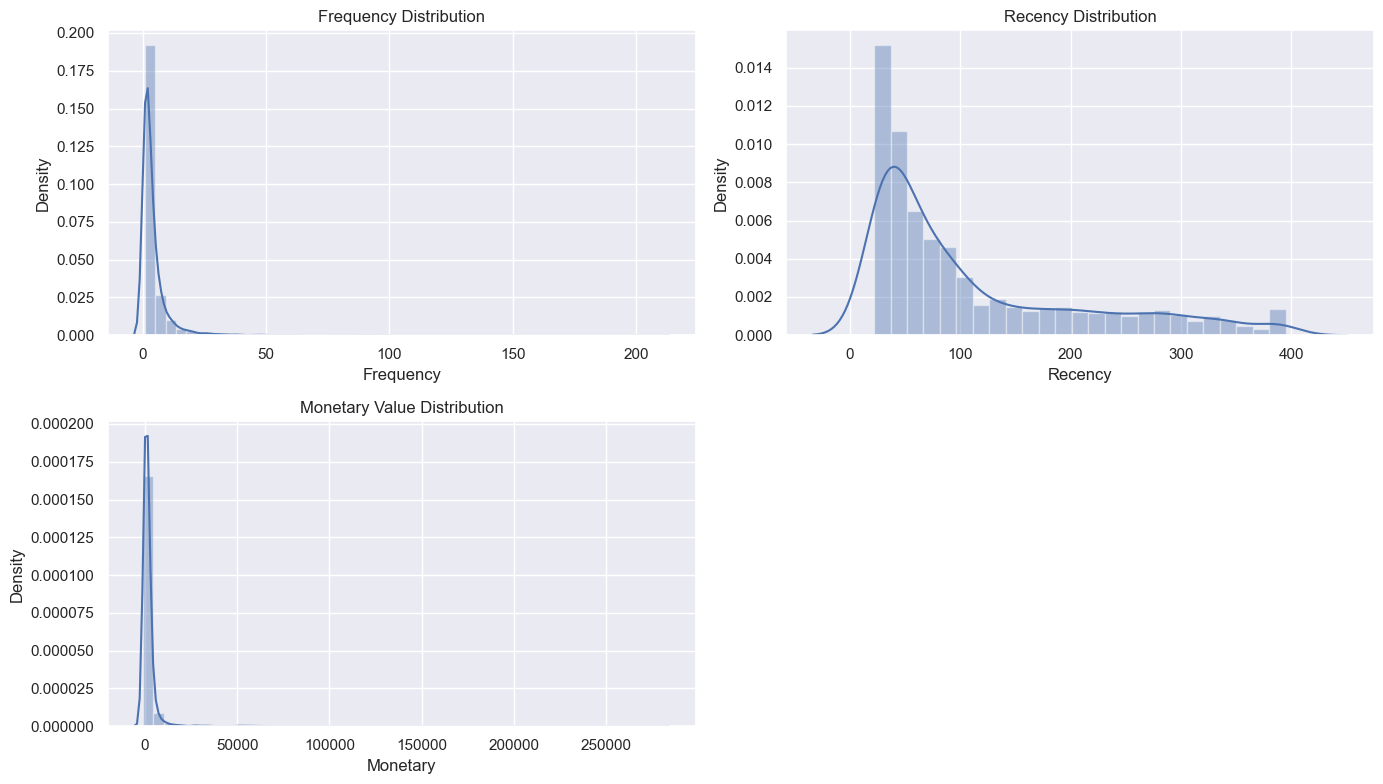

In [40]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_table["Frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_table["Recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_table["Monetary"])
plt.title("Monetary Value Distribution")
plt.tight_layout()
plt.show();

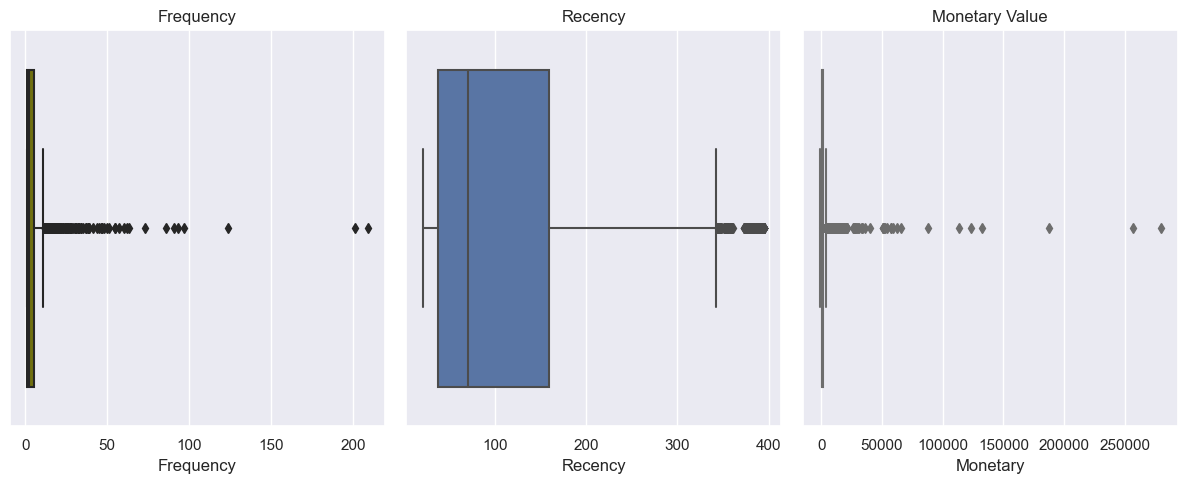

In [41]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_table["Frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_table["Recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_table["Monetary"], color = "salmon")
plt.title("Monetary Value")
plt.tight_layout()
plt.show();

In [42]:
rfm_table[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

Recency        Frequency           Monetary      
                           mean count       mean count         mean count
Segment                                                                  
About to Sleep        73.472464   345   1.168116   345   438.586348   345
At Risk              172.424242   594   2.880471   594   944.206618   594
Cannot Lose          149.553846    65   8.307692    65  2745.479846    65
Champions             26.989214   649  12.223421   649  6647.841171   649
Hibernating          236.419962  1062   1.097928  1062   402.366574  1062
Loyal Customers       53.565000   800   6.523750   800  2671.081939   800
Need Attention        71.333333   186   2.311828   186   809.068065   186
New Customers         27.847826    46   1.000000    46   384.548913    46
Potential Loyalists   37.443320   494   1.997976   494   694.911498   494
Promising             44.340206    97   1.000000    97   306.802887    97

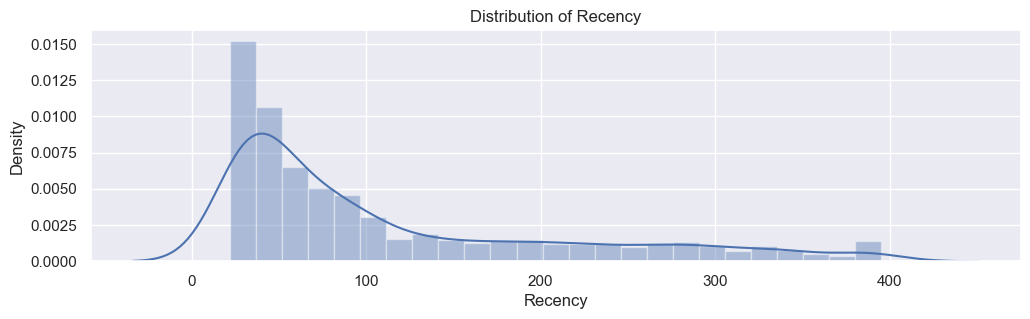

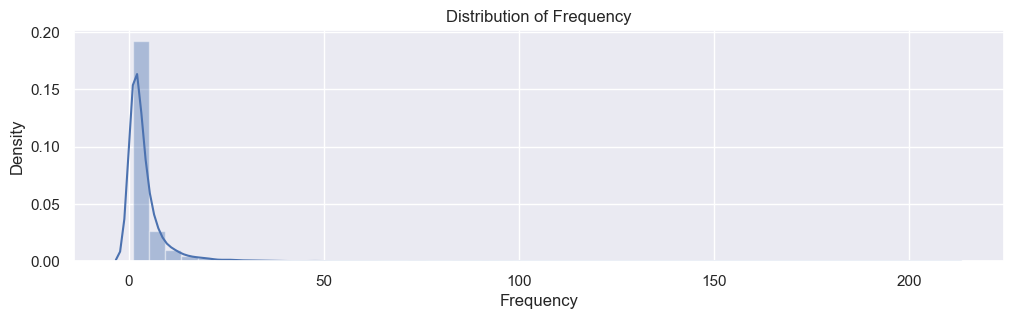

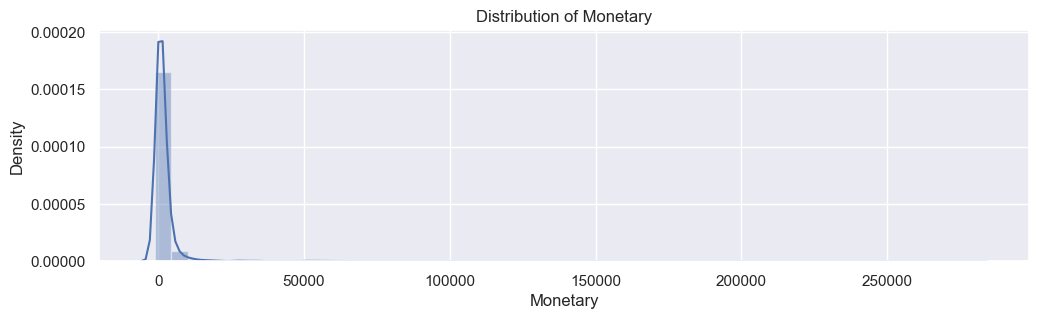

In [43]:
colnames = ['Recency', 'Frequency', 'Monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(rfm_table[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

We grouped the rfm table according to the mean and count values of the segment variable.

### Remarks

3 segments selected for evaluation are "Cannot Lose", "Hibernating" and "Champions".

Number of customers for segments:

Cannot Lose = 65, Hibernating = 1062, Champions = 649

#### Can't Lose Segment;

* The last shopping date of the customers is on average 150 days before.

* Customers have made an average of 8 purchases.

* Customers spent an average of 2745.

#### Hibernating Segment;

* The last shopping date of the customers is 236 days before

* Customers made an average of 1 purchases.

* Customers spent an average of 402


#### Champion Segment:

* The last shopping date of the customers is 27 days before average.
* Customers made an average of 12 purchases.
* Customers spent an average of 6647.


#### Can't Lose Segment;

* Customers in this segment have not recently made a purchase. For this reason, we need to prepare a discount and gift campaign for this segment. These customers made a large number of purchases when they made purchases before. However, recency values are lower than they should be. The campaign to be implemented for these customers should include both items purchased and recommendations based on previous activities. New and popular products associated with the products that they were interested in can also be included in this campaign. Situations that will cause these customers to stop buying need to be investigated.


#### Hibernating Segment;

* Customers in this segment have not made a purchase for a long time. However, by offering discounts, they may be attracted to another purchase.


#### Champions Segment;

* Customers in this segment are responsible for most of the revenue. Campaigns should be implemented to ensure the continuity of the shopping of these customers.


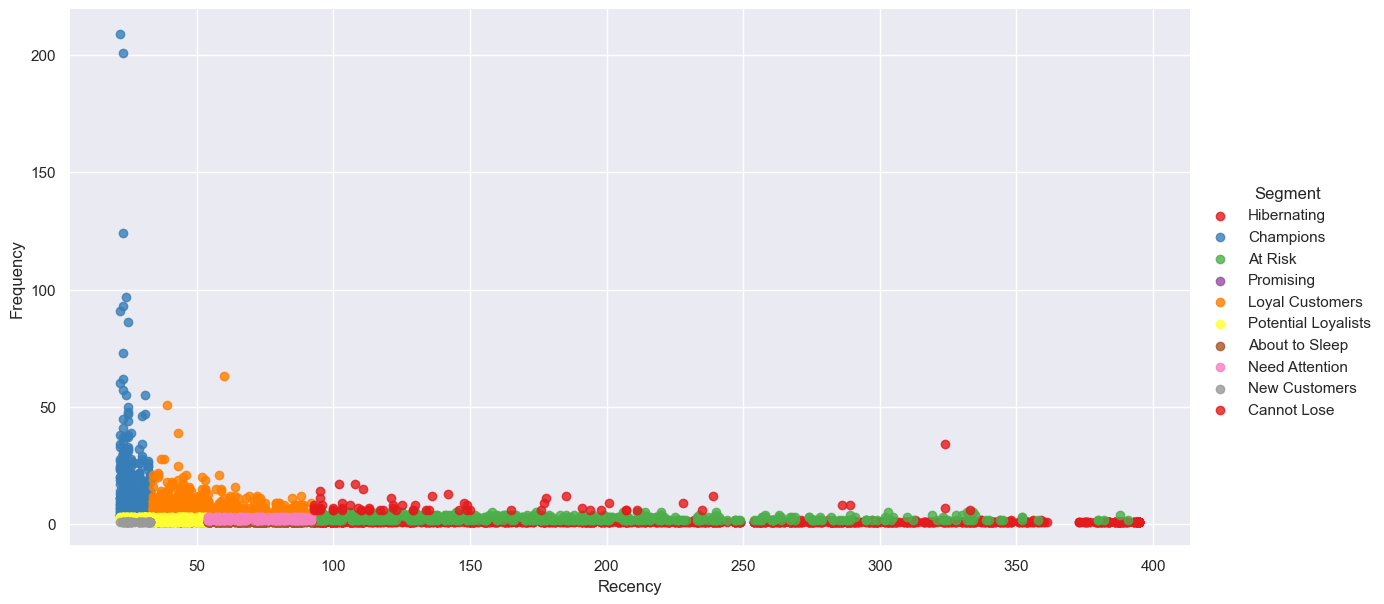

In [44]:
dist = rfm_table[rfm_table.Frequency < 2000 ] # as most of the frequency value is less than 2000 

sns.lmplot(x = 'Recency', y = 'Frequency', hue = 'Segment', data = dist, palette = 'Set1', fit_reg = False, height = 6, aspect = 2)
plt.show();

In [45]:
import squarify

In [46]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm_table.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(1)
# Print the aggregated dataset
rfm_level_agg

Recency Frequency Monetary      
                       mean      mean     mean count
Segment                                             
About to Sleep         73.5       1.2    438.6   345
At Risk               172.4       2.9    944.2   594
Cannot Lose           149.6       8.3   2745.5    65
Champions              27.0      12.2   6647.8   649
Hibernating           236.4       1.1    402.4  1062
Loyal Customers        53.6       6.5   2671.1   800
Need Attention         71.3       2.3    809.1   186
New Customers          27.8       1.0    384.5    46
Potential Loyalists    37.4       2.0    694.9   494
Promising              44.3       1.0    306.8    97

In [47]:
rfm_level_agg.index.tolist()

['About to Sleep',
 'At Risk',
 'Cannot Lose',
 'Champions',
 'Hibernating',
 'Loyal Customers',
 'Need Attention',
 'New Customers',
 'Potential Loyalists',
 'Promising']

#### Recency and Frequency Grid

A low recency and frequency score (bottom left) represents hibernating users who haven’t been active recently or frequently. A high recency and frequency score (top right) represents users who have been active recently and frequently, indicating your app’s champions.

Users are then ranked in order of percentile. For example, a user who has performed the activity most recently would constitute the 100th percentile. Users are then ranked by a score of 1 through 5, based on their percentile, with 5 being the highest

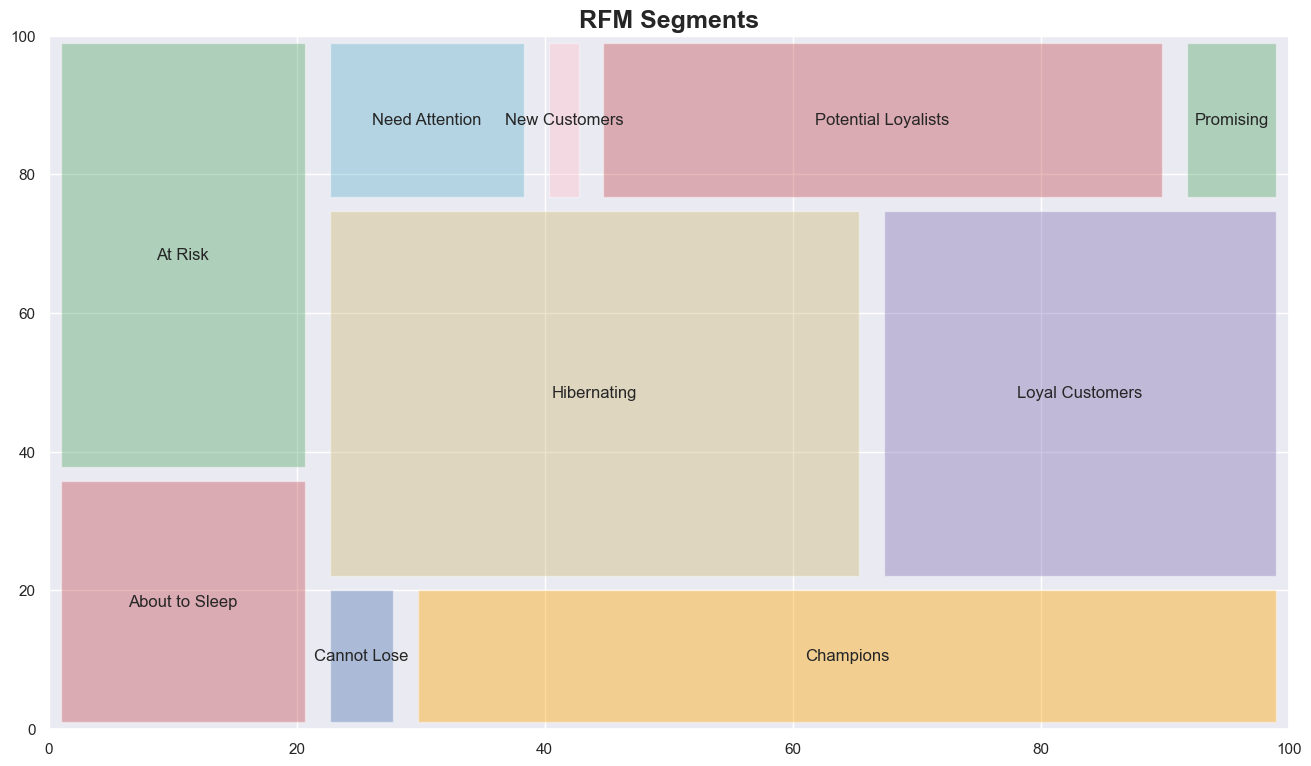

In [48]:
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=rfm_level_agg.index.tolist(), alpha=0.4, pad=0.1, color=['r', 'g', 'b', 'orange', 'y', 'm', 'c', 'pink'] )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis()
plt.savefig('RFM Segments.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});
plt.show();

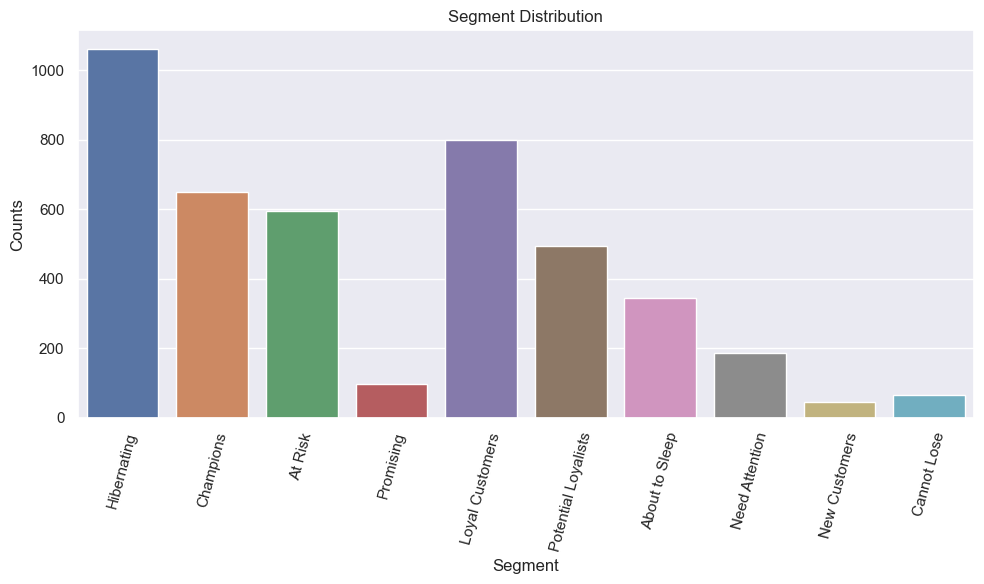

In [49]:
plt.figure(figsize=(10,6))
sns.countplot(rfm_table['Segment'])
plt.ylabel('Counts')
plt.xticks(rotation = 75)
plt.title('Segment Distribution', size=12)
plt.tight_layout()
plt.savefig('Distribution of Segments 2.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});
plt.show();

## K-Means Clustering

In [50]:
rfm_kmeans = rfm_table[['Recency','Frequency', 'Monetary']]

In [52]:
k = range(1, 15)
inertia = []

for i in k:
    model = KMeans(n_clusters = i)
    model.fit(rfm_kmeans)
    inertia.append(model.inertia_)

print(k)
print(inertia)

range(1, 15)
[295149802410.1478, 99904172157.11494, 49096472341.98743, 30150511628.299397, 17780402169.28655, 11598999243.496521, 8401391707.421691, 5450303201.679661, 4014771364.683719, 3102758049.961036, 2378680186.14111, 1922898888.3596213, 1656602746.9098253, 1427967198.4587622]


### Visualization

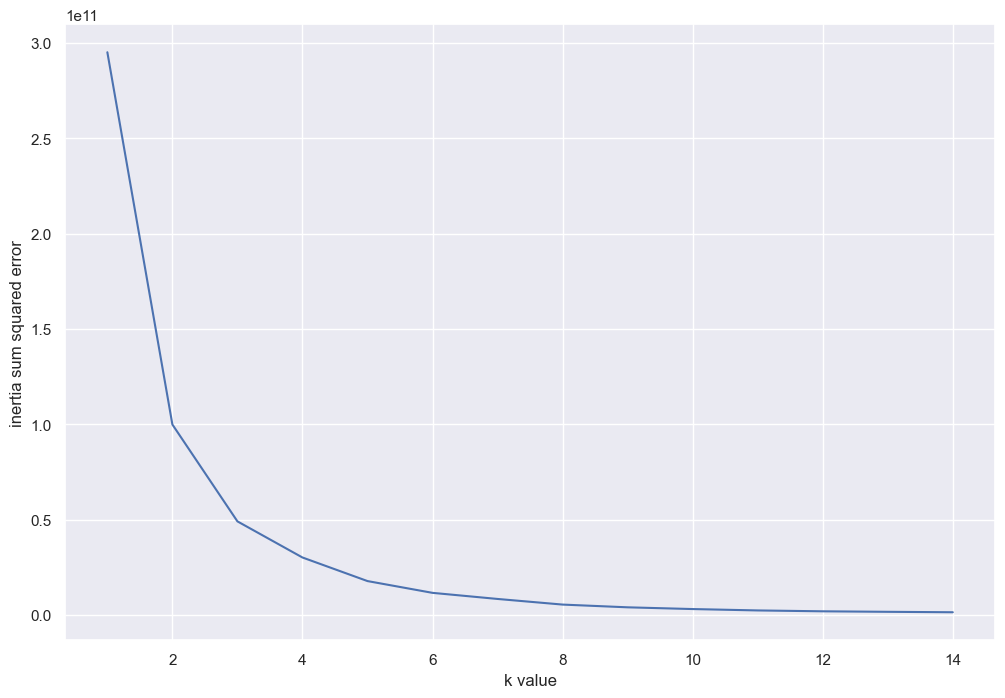

In [55]:
plt.figure(figsize=(12,8))
plt.plot(k, inertia) # Untuk melihat pada sikut dalam plot
plt.xlabel('k value')
plt.ylabel('inertia sum squared error')
plt.show();

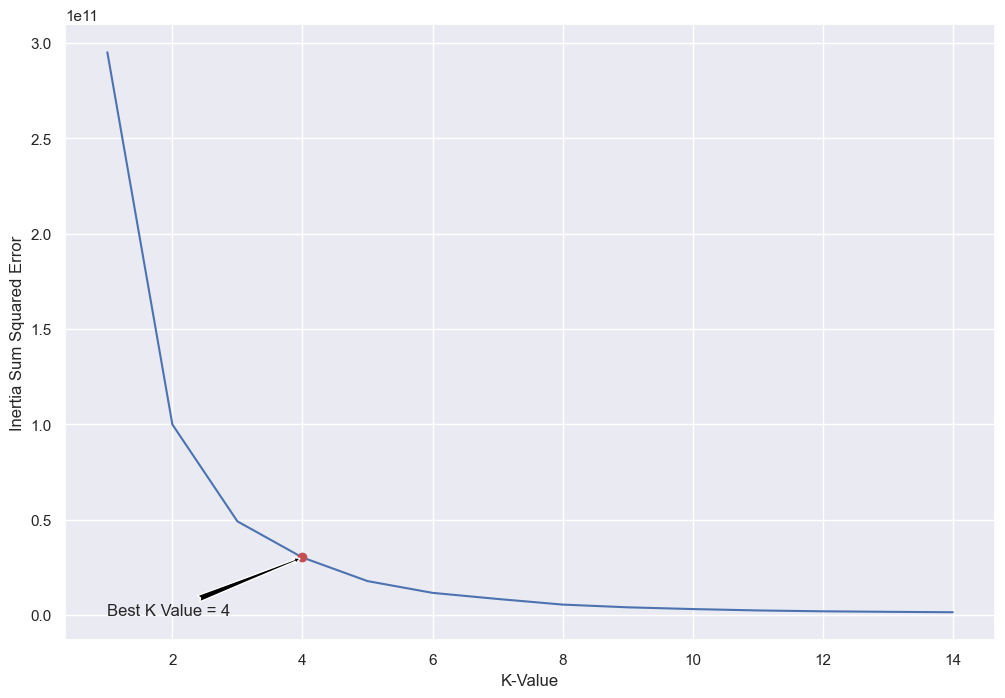

In [56]:
plt.figure(figsize=(12,8))
plt.plot(k, inertia)
plt.xlabel('K-Value')
plt.ylabel('Inertia Sum Squared Error')
plt.plot(k[3], inertia[3], 'ro')
plt.annotate(
    'Best K Value = 4', xy=(k[3], inertia[3]),
    xytext = (1, 20), arrowprops = dict(arrowstyle='fancy',facecolor='black'))
plt.show();

### Using 4 Cluster

In [57]:
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init=100, max_iter=10000, algorithm='full')
kmeans.fit(rfm_kmeans)
pred = kmeans.predict(rfm_kmeans)

In [58]:
pred

array([0, 0, 0, ..., 0, 0, 0])

In [59]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

#### Silhouette Score

In [60]:
score = silhouette_score(rfm_kmeans, kmeans.labels_)
print("Silhoutte Score = ", round(score,2)*100, '%')

Silhoutte Score =  88.0 %


In [61]:
db,slc = {}, {}
for k in range(2, 8):
    # seed of 10 for reproducibility.
    kmeans_normal = KMeans(n_clusters=k, init='k-means++' ,max_iter=10000,random_state=42).fit(rfm_kmeans)
    clusters = kmeans_normal.labels_
    db[k] = davies_bouldin_score(rfm_kmeans,clusters)
    slc[k] = silhouette_score(rfm_kmeans,clusters)
    

##### Visualization

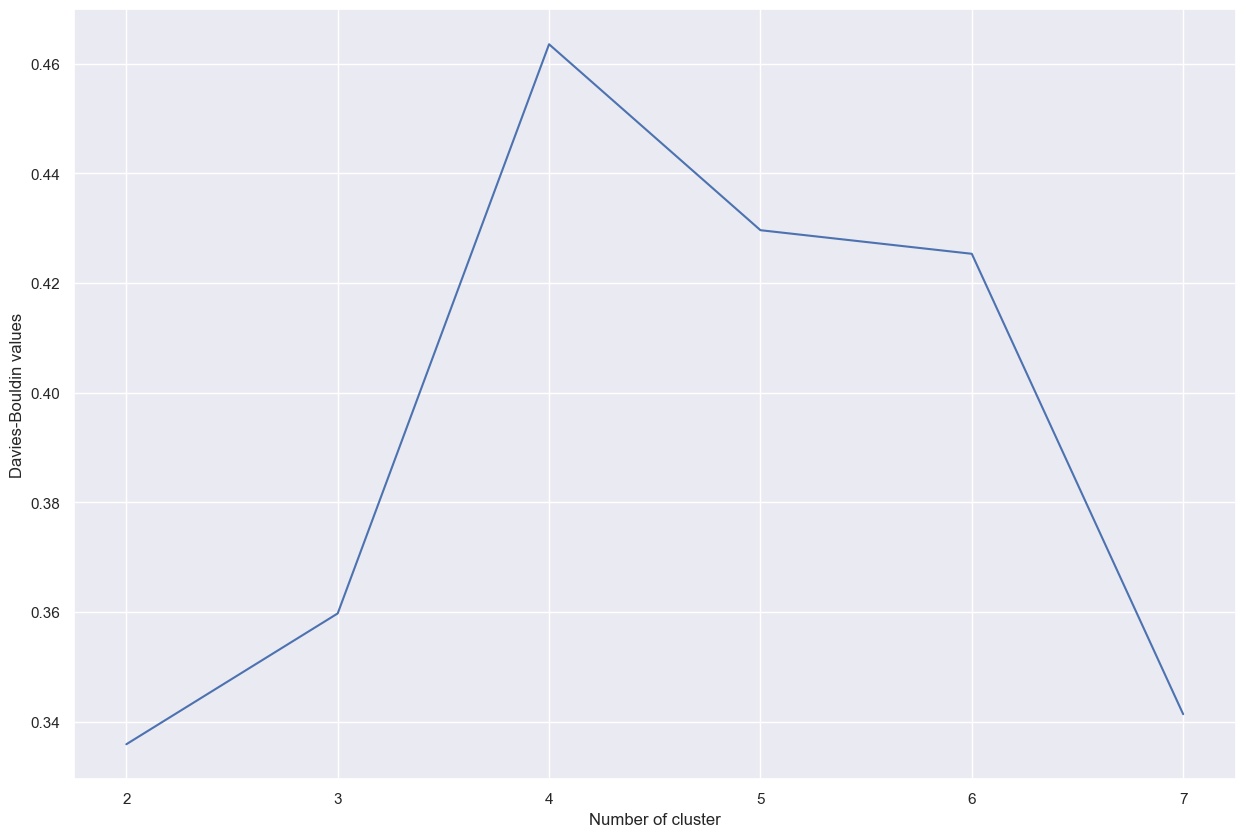

In [62]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show();

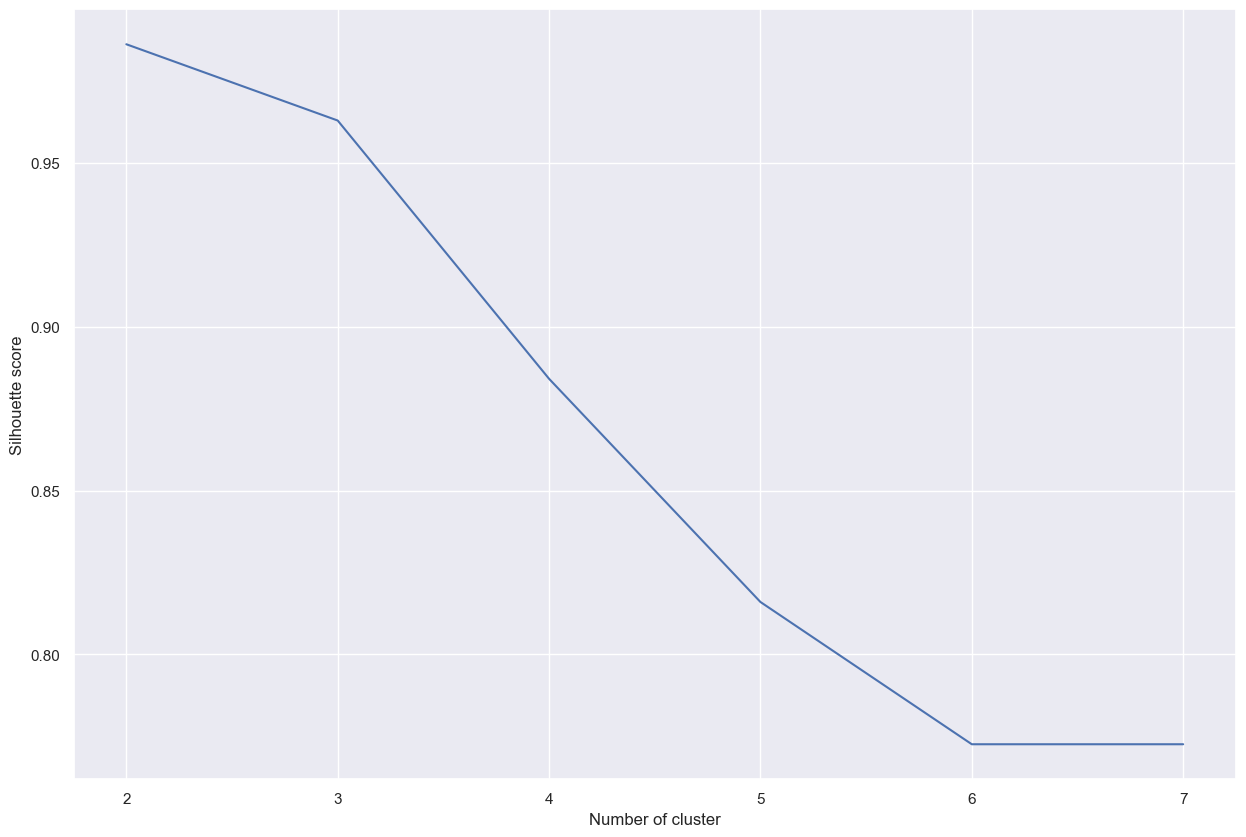

In [63]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show();

In [64]:
pd.Series(pred).value_counts()

0    4218
3     102
2      15
1       3
dtype: int64

#### Scaling Log: K-Values and Clustering

In [65]:
cols = ['Recency', 'Frequency', 'Monetary']

#Generate Feature of Logged value for each Recency, Frequency, and Monetary
for i in cols :
    rfm_kmeans[f'{i}LS'] = np.log(rfm_kmeans[i])

##### Visualization

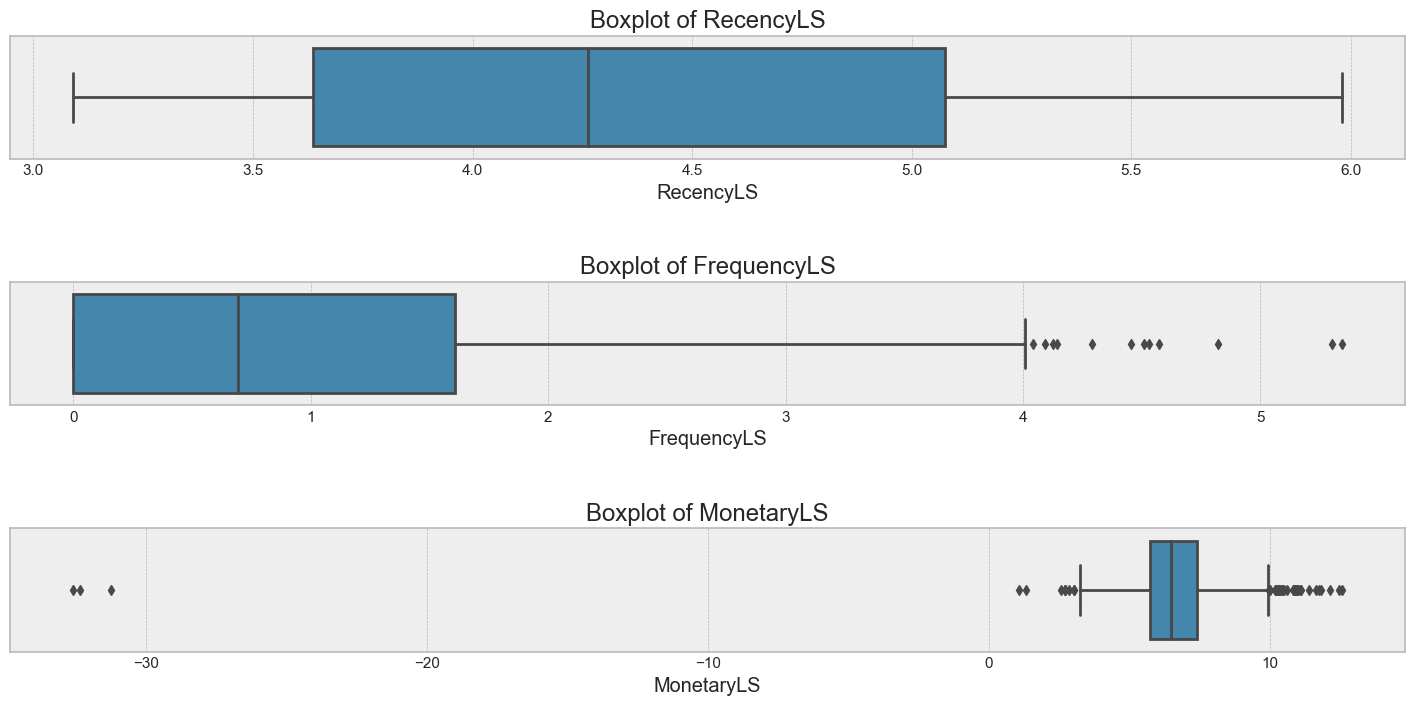

In [66]:
plt.figure(1, figsize=(18,8))

n = 0

for x in ['RecencyLS', 'FrequencyLS', 'MonetaryLS']:
    plt.style.use('bmh')
    n += 1
    plt.subplot(3, 1, n)
    plt.subplots_adjust(hspace = 1)
    sns.boxplot(rfm_kmeans[x])
    plt.title(f"Boxplot of {x}")
plt.show();

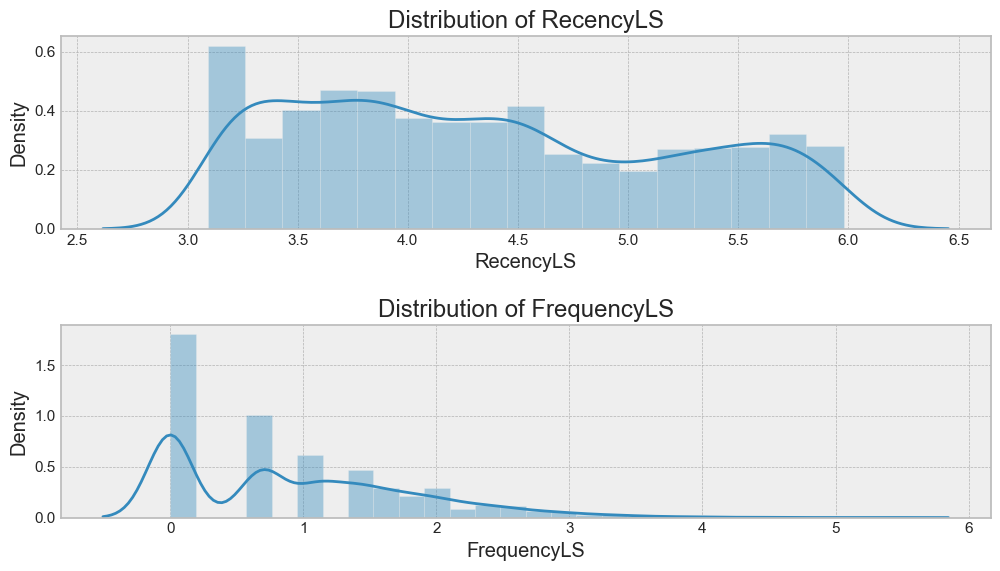

In [67]:
plt.figure(1, figsize=(12,10))

n = 0

for x in ['RecencyLS', 'FrequencyLS']:
    plt.style.use('bmh')
    n += 1
    plt.subplot(3, 1, n)
    plt.subplots_adjust(hspace = .5, wspace = .3)
    sns.distplot(rfm_kmeans[x])
    plt.title(f"Distribution of {x}")
plt.show();